## Configurations for Colab

In [1]:
import sys
IN_COLAB = "google.colab" in sys.modules

if IN_COLAB:
    !apt install python-opengl
    !apt install ffmpeg
    !apt install xvfb
    !pip install PyVirtualDisplay==3.0
    !pip install gymnasium==0.28.1
    !pip install pytorch-tcn
    from pyvirtualdisplay import Display
    
    # Start virtual display
    dis = Display(visible=0, size=(400, 400))
    dis.start()
from IPython.display import clear_output
from torch.optim.lr_scheduler import ExponentialLR

In [2]:
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader, random_split
from pytorch_tcn import TCN
from tqdm import tqdm



# Network

In [3]:
import torch
import torch.nn as nn

class Inception1DModule(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Inception1DModule, self).__init__()
        self.branch1 = nn.Conv1d(in_channels, out_channels, kernel_size=1)
        
        self.branch3 = nn.Sequential(
            nn.Conv1d(in_channels, out_channels, kernel_size=1),
            nn.Conv1d(out_channels, out_channels, kernel_size=3, padding=1)
        )

        self.branch5 = nn.Sequential(
            nn.Conv1d(in_channels, out_channels, kernel_size=1),
            nn.Conv1d(out_channels, out_channels, kernel_size=5, padding=2)
        )

        self.branch_pool = nn.Sequential(
            nn.MaxPool1d(kernel_size=3, stride=1, padding=1),
            nn.Conv1d(in_channels, out_channels, kernel_size=1)
        )

    def forward(self, x):
        branch1 = self.branch1(x)
        branch3 = self.branch3(x)
        branch5 = self.branch5(x)
        branch_pool = self.branch_pool(x)
        outputs = [branch1, branch3, branch5, branch_pool]
        return torch.cat(outputs, 1)

class Network(nn.Module):
    def __init__(self, num_inputs, num_outputs):
        super(Network, self).__init__()
        self.inception1 = Inception1DModule(num_inputs, 8)
        self.inception2 = Inception1DModule(32, 16)
        self.inception3 = Inception1DModule(64, 32)
        self.inception4 = Inception1DModule(128, 64)
        self.lstm = nn.LSTM(input_size=256, hidden_size=64, num_layers=1, batch_first=True)
        self.Linear_layers = nn.Sequential(
            nn.Linear(64, num_outputs),
            nn.ReLU(),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = x.permute(0, 2, 1)
        x = self.inception1(x)
        x = self.inception2(x)
        x = self.inception3(x)
        x = self.inception4(x)
        
        
        # print("================================")
        # print(x.shape)
        # print("================================")
        x = x.permute(0, 2, 1)  # Change shape for LSTM (batch, seq_len, feature)
        x, _ = self.lstm(x)  # Apply LSTM
        x = x[:, -1, :]  # Take the output of the last LSTM time step
        x = self.Linear_layers(x)  # Apply linear layers
        return x


## Data processing

In [6]:

# Set the device to GPU 2 (index 1)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [17]:
# intern
from Utils.Merge_data import get_data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

df = get_data('./data/sensor_2')

#  drop Time(UTC+0) columns:
df.drop(columns=['Time(UTC+0)'], inplace=True)

# normalized

normalized_data = scaler.fit_transform(df)
df = pd.DataFrame(normalized_data, columns=df.columns)



num_features = 4
sequence_length = 128

# Create sequences
def create_sequences(data, seq_length):
    sequences = []
    for i in range(len(data) - seq_length):
        seq = data[i:i + seq_length]
        sequences.append(seq)
    return np.array(sequences)

# Convert dataframe to numpy array
data = df.values

# Create sequences
sequences = create_sequences(data, sequence_length)

# Convert sequences to PyTorch tensors
X = torch.tensor(sequences, dtype=torch.float32).to(device)

# Create target tensor (e.g., predicting the closing price)
y = torch.tensor(df['PM2.5(μm/m^3)'][sequence_length:].values, dtype=torch.float32).unsqueeze(-1).to(device)

# Calculate the number of samples
num_samples = len(X)

# Calculate the number of samples for each set
num_train = int(num_samples * 0.8)
num_val = int(num_samples * 0.1)
num_test = num_samples - num_train - num_val

# Create dataset
dataset = TensorDataset(X, y)

# Split the dataset sequentially
train_dataset = TensorDataset(X[:num_train], y[:num_train])
val_dataset = TensorDataset(X[num_train:num_train+num_val], y[num_train:num_train+num_val])
test_dataset = TensorDataset(X[num_train+num_val:], y[num_train+num_val:])

<Figure size 1500x500 with 0 Axes>

In [18]:

# Create DataLoaders for each set
batch_size = 512

# Disable shuffling to maintain temporal order for LSTM
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Train

In [9]:
def _plot(
            train_loss,
            val_loss,
            n:int = None,
        ):
            # Plot the training progresses
            clear_output(True)
            plt.figure(figsize=(9, 6))  # Adjusted figure size
            
            if len(train_loss) > 0 and n != None:
                plt.title('Loss')
                plt.plot(train_loss[-n:], label='Train')
                plt.plot(val_loss[-n:], label='Validation')
            
                
                
                
                
            elif len(train_loss) > 0 and n == None:
                plt.title('Loss')
                plt.plot(train_loss, label='Train')
                plt.plot(val_loss, label='Validation')
                        
            plt.tight_layout()  # Adjust subplots to fit into the figure
            plt.legend()
            plt.savefig('Hybrid_training.png')
            plt.show()

In [10]:
# Instantiate the model, loss function, and optimizer
model = Network(num_inputs=4, num_outputs=1).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = ExponentialLR(optimizer, gamma=0.95)
# Create a directory to save model checkpoints
checkpoint_dir = 'model_checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)



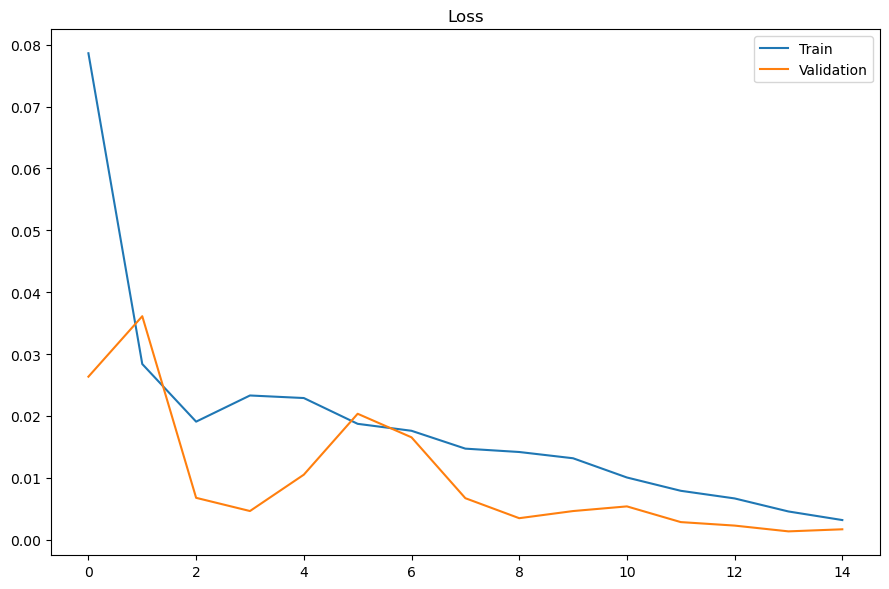

Training: 100%|██████████| 15/15 [00:02<00:00,  6.39it/s, Train Loss=0.00315, Val Loss=0.00166]


In [11]:
# Training loop
num_epochs = 15

train_losses = []
val_losses = []

train_progress = tqdm(range(num_epochs), desc="Training", position=0, leave=True)
for epoch in train_progress:
    model.train()
    train_loss = 0.0
    
    for inputs, targets in tqdm(train_loader, desc=f"Epoch {epoch+1}", position=1, leave=False):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * inputs.size(0)
    
    train_loss /= num_train
    train_losses.append(train_loss)
    
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss.item() * inputs.size(0)
    
    val_loss /= num_val
    val_losses.append(val_loss)
    
    train_progress.set_postfix({"Train Loss": train_loss, "Val Loss": val_loss})

    # Save the model checkpoint
    checkpoint_path = os.path.join(checkpoint_dir, f'model_epoch_{epoch+1}.pth')
    torch.save(model.state_dict(), checkpoint_path)

    # Plot losses after each epoch
    _plot(train_losses, val_losses)

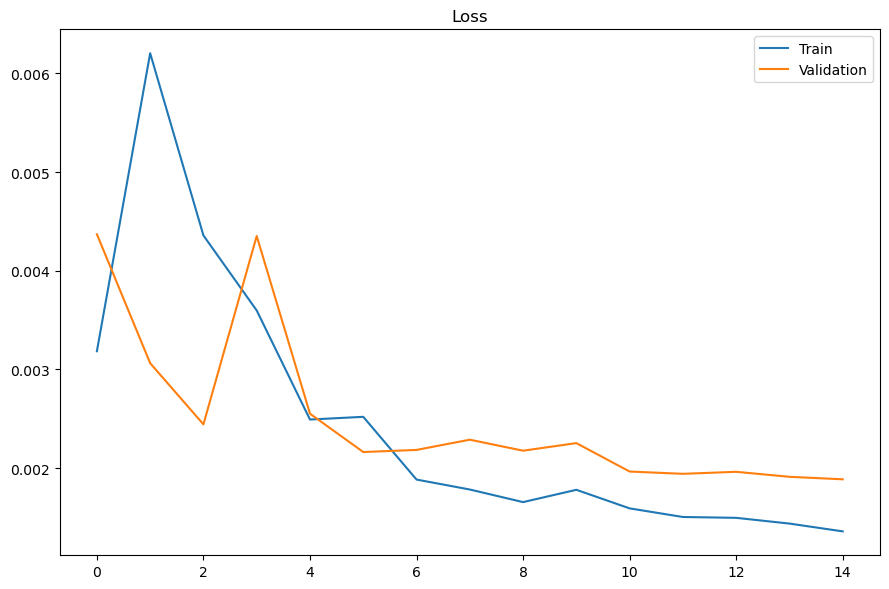

Training: 100%|██████████| 15/15 [00:02<00:00,  6.89it/s, Train Loss=0.00136, Val Loss=0.00189]


In [19]:
# Training loop
num_epochs = 15

train_losses = []
val_losses = []

train_progress = tqdm(range(num_epochs), desc="Training", position=0, leave=True)
for epoch in train_progress:
    model.train()
    train_loss = 0.0
    
    for inputs, targets in tqdm(train_loader, desc=f"Epoch {epoch+1}", position=1, leave=False):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * inputs.size(0)
    
    train_loss /= num_train
    train_losses.append(train_loss)
    
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss.item() * inputs.size(0)
    
    val_loss /= num_val
    val_losses.append(val_loss)
    
    train_progress.set_postfix({"Train Loss": train_loss, "Val Loss": val_loss})

    # Save the model checkpoint
    checkpoint_path = os.path.join(checkpoint_dir, f'model_epoch_{epoch+1}.pth')
    torch.save(model.state_dict(), checkpoint_path)

    # Plot losses after each epoch
    _plot(train_losses, val_losses)

## Test

Run the trained agent (1 episode).

In [20]:

# Evaluate the model on the test set
model.eval()
test_loss = 0.0
with torch.no_grad():
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        test_loss += loss.item() * inputs.size(0)

test_loss /= num_test

print(f'Test Loss: {test_loss:.4f}')

Test Loss: 0.0012


In [21]:
# Load the dataset
df_descale = get_data('./data/')

# Calculate min and max for scaling
min_P = df_descale['PM2.5(μm/m^3)'].min()
max_P = df_descale['PM2.5(μm/m^3)'].max()

# Print min and max for verification
print("Minimum PM2.5(μm/m^3):", min_P)
print("Maximum PM2.5(μm/m^3):", max_P)


Minimum PM2.5(μm/m^3): 3.3
Maximum PM2.5(μm/m^3): 129.46


<Figure size 1500x500 with 0 Axes>

In [22]:
# intern
from Utils.Merge_data import get_data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

df = get_data('./data/sensor_3')

#  drop Time(UTC+0) columns:
df.drop(columns=['Time(UTC+0)'], inplace=True)

# normalized

normalized_data = scaler.fit_transform(df)
df = pd.DataFrame(normalized_data, columns=df.columns)



num_features = 4
sequence_length = 128

# Create sequences
def create_sequences(data, seq_length):
    sequences = []
    for i in range(len(data) - seq_length):
        seq = data[i:i + seq_length]
        sequences.append(seq)
    return np.array(sequences)

# Convert dataframe to numpy array
data = df.values

# Create sequences
sequences = create_sequences(data, sequence_length)

# Convert sequences to PyTorch tensors
X = torch.tensor(sequences, dtype=torch.float32).to(device)

# Create target tensor (e.g., predicting the closing price)
y = torch.tensor(df['PM2.5(μm/m^3)'][sequence_length:].values, dtype=torch.float32).unsqueeze(-1).to(device)

# Calculate the number of samples
num_samples = len(X)

# Calculate the number of samples for each set
num_train = int(num_samples * 0.8)
num_val = int(num_samples * 0.1)
num_test = num_samples - num_train - num_val

# Create dataset
dataset = TensorDataset(X, y)

<Figure size 1500x500 with 0 Axes>

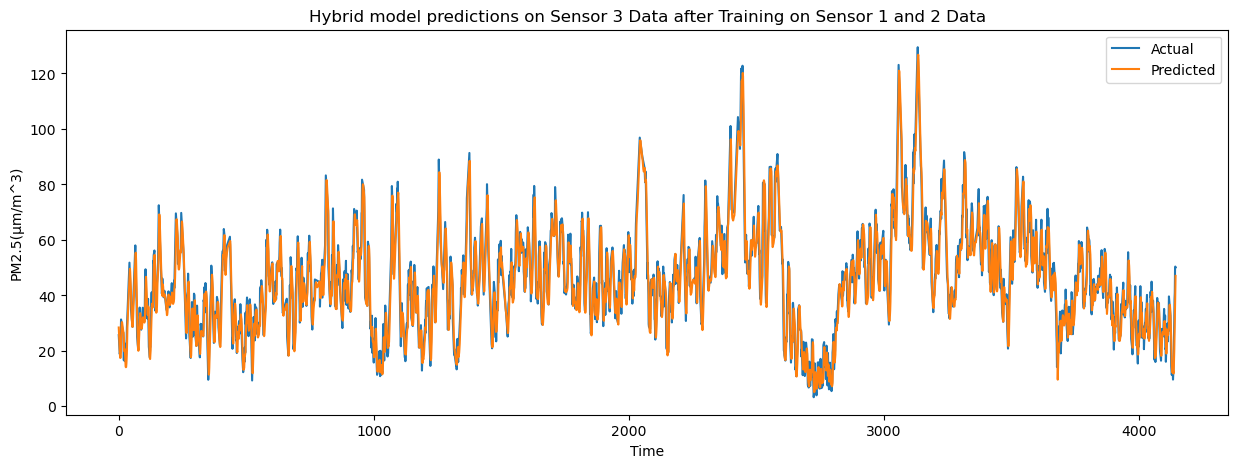

In [23]:
# Generate predictions on the entire dataset in order
all_loader = DataLoader(dataset, batch_size=1, shuffle=False)
all_predictions = []
model.eval()
with torch.no_grad():
    for inputs, _ in all_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        all_predictions.append(outputs.item())

# Convert predictions to numpy array
all_predictions = np.array(all_predictions)
# Descale all_predictions
descaled_all_predictions = all_predictions * (max_P - min_P) + min_P

# Descale df['PM2.5(μm/m^3)']
descaled_actual_values = df['PM2.5(μm/m^3)'].values[sequence_length:] * (max_P - min_P) + min_P

# Plot actual vs predicted
plt.figure(figsize=(15, 5))
plt.title('Hybrid model predictions on Sensor 3 Data after Training on Sensor 1 and 2 Data') 
plt.plot(descaled_actual_values, label='Actual')
plt.plot(descaled_all_predictions, label='Predicted')
plt.xlabel('Time')
plt.ylabel('PM2.5(μm/m^3)')
plt.legend()
plt.savefig('Hybrid_2.png')
plt.show()